In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
import numpy as np
import healpy as hp

In [47]:
# download raw data

planck30 = hp.read_map('../data_files/LFI_SkyMap_030_1024_R2.01_full.fits')
planck44 = hp.read_map('../data_files/LFI_SkyMap_044_1024_R2.01_full.fits')
planck70 = hp.read_map('../data_files/LFI_SkyMap_070_1024_R2.01_full.fits')
planck100 = hp.read_map('../data_files/HFI_SkyMap_100_2048_R2.02_full.fits')
planck143 = hp.read_map('../data_files/HFI_SkyMap_143_2048_R2.02_full.fits')
planck217 = hp.read_map('../data_files/HFI_SkyMap_217_2048_R2.02_full.fits')
planck353 = hp.read_map('../data_files/HFI_SkyMap_353_2048_R2.02_full.fits')

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/Users/andrewlewis/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [48]:
# lower the resolution of the maps

planck30 = hp.ud_grade(planck30, 512)
planck44 = hp.ud_grade(planck44, 512)
planck70 = hp.ud_grade(planck70, 512)
planck100 = hp.ud_grade(planck100, 512)
planck143 = hp.ud_grade(planck143, 512)
planck217 = hp.ud_grade(planck217, 512)
planck353 = hp.ud_grade(planck353, 512)

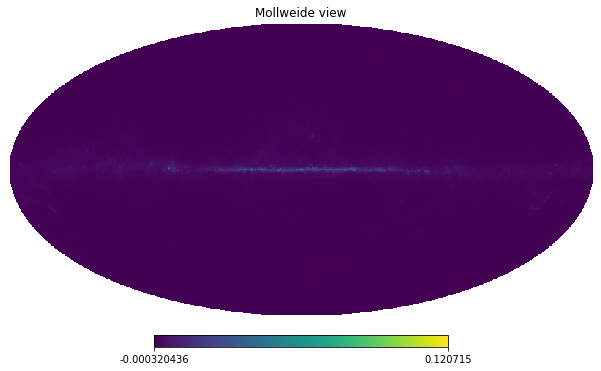

In [49]:
# example plot of raw data

hp.mollview(planck217,nest=False)

In [50]:
# implement the Lagrange method

map_array = np.array([planck30, planck44, planck70, planck100, planck143, planck217, planck353])

# define weighted map sum function

def map_sum(w):
    """Given an array of weights w,returns a weighted sum of the maps"""
    return w@map_array

In [82]:
def get_H(map_array):
    i = 0
    j = 0
    H = np.zeros((len(map_array), len(map_array)))
    
    for m in map_array:
        
        j = 0
        for n in map_array:
            product = m*n
            product_sum = np.sum(product)
            H[i, j] = product_sum
            j+=1
        i+=1
    return H

In [84]:
H = get_H(map_array)



[[ 13.01503803   5.1006133    2.45012009   2.79406481   2.74030215
    9.48263945  66.74070916]
 [  5.1006133    2.05198609   1.02292188   1.12053586   1.08009634
    3.6175037   25.22056681]
 [  2.45012009   1.02292188   0.59828911   0.62491524   0.59063124
    1.8407644   12.55415337]
 [  2.79406481   1.12053586   0.62491524   0.79433796   0.74548569
    2.59678152  17.82935158]
 [  2.74030215   1.08009634   0.59063124   0.74548569   0.76963261
    2.63757515  18.42892246]
 [  9.48263945   3.6175037    1.8407644    2.59678152   2.63757515
    9.74850931  68.69577659]
 [ 66.74070916  25.22056681  12.55415337  17.82935158  18.42892246
   68.69577659 488.03671853]]


In [53]:
e = np.ones(len(map_array))

In [54]:
w = (np.linalg.inv(H)@e) / (e.T@H@e)

In [55]:
print(w)
print(np.sum(w))
print(w/np.sum(w))
opt_map = map_sum(w/np.sum(w))
print(opt_map)

[-0.00288621  0.0104061  -0.0195659   0.01101462  0.02525271 -0.00272827
 -0.00060967]
0.02088339220663807
[-0.13820596  0.4982956  -0.93691211  0.52743458  1.20922469 -0.13064282
 -0.02919399]
[-1.65588589e-04 -7.40888188e-05 -1.31758658e-05 ...  9.81450736e-05
  1.01674421e-04  9.97091627e-05]


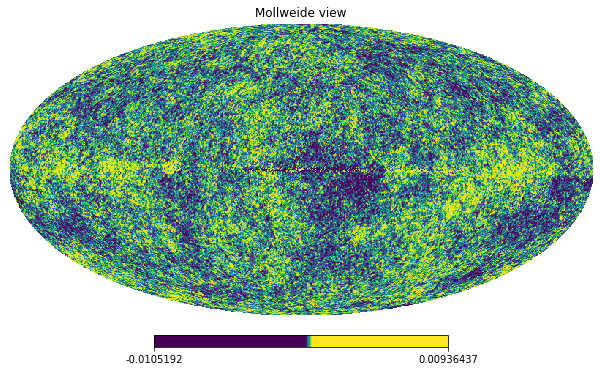

In [56]:
hp.mollview(opt_map, nest=False, norm='hist')

In [57]:
#Slices up the map into different regions
def sliceFixer(num_slices,array_maps):
    #Creates n different slices of the cmb, and weights them correspondingly
    length_maps = len(array_maps[0])
    slicedUpMaps = []
    #Start for the slices
    lowerBound = 0
    upperBound = int(length_maps/num_slices)
    
    for i in range(num_slices):   #Goes over the number of slices
        mapSlicesToAdd = []
        for j in array_maps:
            mapSlicesToAdd.append(j[lowerBound:upperBound])
        slicedUpMaps.append(mapSlicesToAdd)  #Add the map slices
        lowerBound = upperBound
        upperBound += int(length_maps/num_slices)
    return slicedUpMaps
        

        
        

    
    
    
    

In [75]:

a = sliceFixer(6,map_array)
print(np.shape(a))
a = np.asarray(a)

newMap = []
for i in range(np.shape(a)[0]):
    newMap.append(a[i][0])
print(newMap)
newMap = np.asarray(newMap)
newMap = newMap.flatten()
print(np.shape(newMap))

(6, 7, 524288)
[array([-3.90142095e-05, -9.70940164e-05, -6.99814028e-05, ...,
        8.61936787e-05,  9.50128924e-06,  5.56160912e-05]), array([1.44563887e-06, 4.16898811e-05, 1.21927787e-04, ...,
       2.59423741e-04, 3.17257694e-04, 2.15293916e-04]), array([0.00026486, 0.00024318, 0.00022059, ..., 0.00073919, 0.00077746,
       0.00064941]), array([0.00067957, 0.00060147, 0.00052929, ..., 0.00028529, 0.00017303,
       0.00017724]), array([ 2.30278283e-04,  3.51360464e-04,  3.61222781e-04, ...,
        1.05474383e-04,  4.32631959e-05, -6.82717928e-06]), array([ 6.46951448e-05,  3.09753603e-05,  8.52580688e-05, ...,
        4.71518988e-05,  3.40329252e-05, -9.43145551e-06])]
(3145728,)


In [90]:
#now can I use the same H
print(np.shape(a[0]))
get_H(a[3])

(7, 524288)


array([[  7.81643731,   3.09038414,   1.50590065,   1.63056395,
          1.54963075,   5.26461226,  36.86795492],
       [  3.09038414,   1.25062808,   0.63303279,   0.65807703,
          0.61370385,   2.02091907,  14.03592734],
       [  1.50590065,   0.63303279,   0.38248923,   0.37845311,
          0.34351005,   1.04511868,   7.09444875],
       [  1.63056395,   0.65807703,   0.37845311,   0.45912554,
          0.41639205,   1.4384958 ,   9.86244023],
       [  1.54963075,   0.61370385,   0.34351005,   0.41639205,
          0.41508253,   1.41684892,   9.88969679],
       [  5.26461226,   2.02091907,   1.04511868,   1.4384958 ,
          1.41684892,   5.23059499,  36.77422755],
       [ 36.86795492,  14.03592734,   7.09444875,   9.86244023,
          9.88969679,  36.77422755, 260.34732977]])

In [124]:
def slicedWeightGetter(mapSlice_array):
    '''
    returns the weight for a given slice
    Params
    ------
    mapSlice_array: a slice of a given portion of the sky over all the maps we are normalizing over
    
    Returns
    -------
    w = Array of weights for the map
    '''
    #Get s
    H = get_H(mapSlice_array)
    e = np.ones(len(mapSlice_array))
    
    w = (np.linalg.inv(H)@e) / (e.T@H@e)
    w = w/np.sum(w)  #apply the constraint all the weights must equal 1
    
    return w

def sliceCMBFixer(num_slices,map_array):
    '''
    This method will implement the slicing method to improve CMB foreground removal based on the assumption that
    the CMB acts as a blackbody
    Params
    ------
    num_slices: the number of slices we are taking of the map
    map_array: the array of maps at different frequencies of the CMB
    
    Returns
    -------
    fixed_map: the map that has had the foreground cleared using the slicing method
    
    

    '''
    #Slice up the cmb into different maps
    slicedMap = sliceFixer(num_slices, array_maps=map_array)
    
    #Apply linear algebra method (seen in class) to each map
    weights = []  #array of weights corresponding to each slice
    for i in range(num_slices):
        weights.append(slicedWeightGetter(slicedMap[i]))
    weights = np.asarray(weights)
    #Recombine the slices with the new weights
    fixed_map = []
    for i in range(num_slices):
        currentSlice = slicedMap[i]
        currentSlice = np.asarray(currentSlice)
        fixedPortion = weights[i]@currentSlice
        fixed_map.append(fixedPortion)
    #convert to a numpy array and flatten
    fixed_map = np.asarray(fixed_map).flatten()
    return fixed_map
    
    
        
    
    
    
    
    

In [182]:
a = (sliceCMBFixer(12,map_array))

3145728
[1. 1. 1. ... 1. 1. 1.]


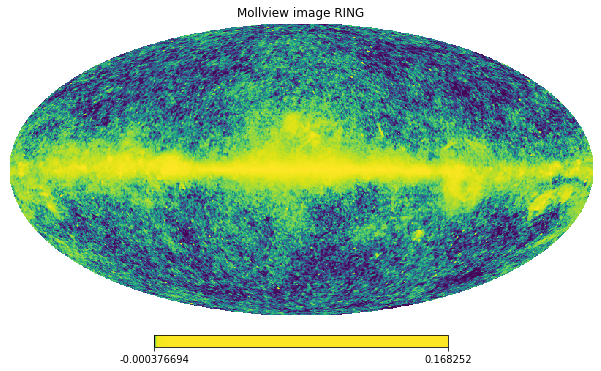

In [166]:
#Me messing around

print(hp.nside2npix(512))
shape = np.arange(hp.nside2npix(16))
shape = np.linspace(0,1,32)
shape = np.ones(3145728)
print(shape)
shape[int(3145728/3):int(3145728/12)*2] = 3
hp.mollview(newMap, title="Mollview image RING",norm= 'HIST')

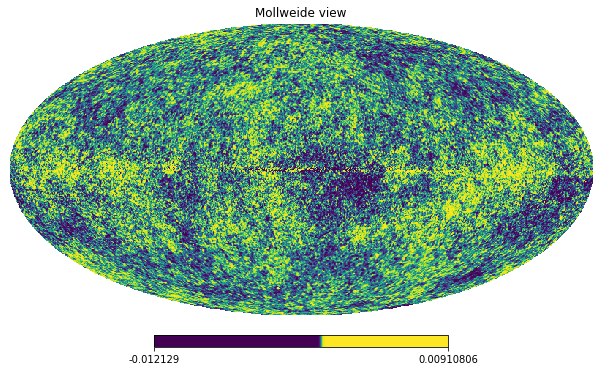

In [183]:
hp.mollview(a, norm = 'Hist')

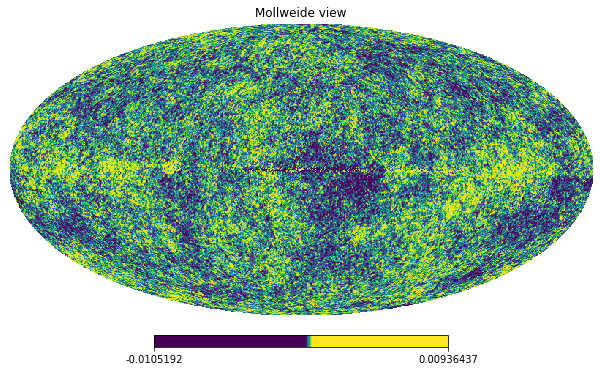

In [184]:
hp.mollview(opt_map, nest=False, norm='hist')

In [1]:
#Louis' part starts here

In [2]:
sph_map_array = []
#create an array of the maps in spherical harmonic spaces
for i in map_array: 
    sph_map_array.append(hp.sphtfunc.map2alm(i, lmax = 1024))

NameError: name 'map_array' is not defined

In [3]:
def wLCalc(cL, e):
    return (np.linalg.inv(cL)@e) / (e.T@np.linalg.inv(cL)@e)

In [9]:
#initialize cl matrix list
cLArray = np.zeros((7,7,1025))

NameError: name 'np' is not defined

In [5]:
countI = 0
countJ = 0
#fill out the cl matrix list for each cross-power spectrum using equation 13
for i in map_array:
    countJ = 0
    for j in map_array:
        element = hp.sphtfunc.anafast(i, map2 = j, lmax = 1024)
        cLArray[countI, countJ] = element
        countJ += 1
    countI += 1

NameError: name 'map_array' is not defined

In [6]:
#initialize weights list
wLArray = np.zeros((7,1025))

NameError: name 'np' is not defined

In [7]:
#fill out weights list using equation 12
countI = 0
while countI < 1025:
    wLArray[:,countI] = wLCalc(cLArray[:,:,countI], e)
    countI += 1
print(wLArray)
wLArray.shape

NameError: name 'cLArray' is not defined

In [8]:
almArray = []

In [10]:
#calculate the new alm's using equation 10
lCounter = 0
while lCounter < 1025:
    mCounter = 0
    mMax = lCounter+1
    print("We are at l = ", lCounter)
    while mCounter < mMax:
        almList = np.asarray([sph_map_array[0][mCounter], sph_map_array[1][mCounter], sph_map_array[2][mCounter], sph_map_array[3][mCounter], sph_map_array[4][mCounter], sph_map_array[5][mCounter], sph_map_array[6][mCounter]])
        newAlm = almList.T@wLArray[:,lCounter]
        almArray.append(newAlm)
        mCounter += 1
    lCounter += 1

We are at l =  0


NameError: name 'np' is not defined

In [ ]:
npALM = np.asarray(almArray)

In [ ]:
new_sph_map = hp.sphtfunc.alm2map(npALM, nside = 1024,lmax = 1024)

In [ ]:
hp.mollview(new_sph_map, nest=False, norm='hist')